# Backpropagation

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import exp
from numpy import newaxis
import copy
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import colorConverter
from PIL import Image
from matplotlib.pyplot import imshow
import os
from itertools import product
import random

%matplotlib inline 

### Notation

$\textbf{p}$, $\textbf{a}$ and $\textbf{t}$ represent the input to the network, output of the network and the target output of the network respectively.

We have $M$ layers numbered as $\{1, 2, ... , M\}$.

$\textbf{f}^m$ represents the column vector of functions of neurons $1$ through $S^m$ (the number of neurons in $m$th layer).

$\textbf{s}^m$ represents the sensitivity matrix of layer $m$. Sensitivity of $i$th neuron in $m$th layer is defined as:

$$s_i^m = \frac{\partial \hat{F}}{\partial n_i^m}$$

where $\hat{F}(\textbf{x}) = (\textbf{t} - \textbf{a})^T(\textbf{t} - \textbf{a})$ is the error function.

$\dot{\textbf{F}}^m(\textbf{n}^m)$  is a (square) diagonal matrix of size $S^m \times S^m$ with diagonal elements as the derivate of the transfer function with respect to weighted sum of inputs of all $S^m$ neurons.

### Algorithm

First step is to propagate input forward through the network:
    
$$\textbf{a}^0 = \textbf{p}$$

$$\textbf{a}^{m+1} = \textbf{f}^{m+1}(\textbf{W}^{m+1} \textbf{a}^m + \textbf{b}^{m+1})$$

$$\textbf{a} = \textbf{a}^M$$

Next step is to propagate the sensitivities backwards ("the backpropagation"):

$$\textbf{s}^M = -2 \dot{\textbf{F}}(\textbf{n}^M) (\textbf{t} - \textbf{a})$$

$$\textbf{s}^m = \dot{\textbf{F}}^m (\textbf{n}^m) (\textbf{W}^{m+1})^T \textbf{s}^{m+1} $$

Finally, the weights and biases are updated using the approximate steepest descent rule:

$$\textbf{W}^m(k+1) = \textbf{W}^m (k) - \alpha \textbf{s}^m (\textbf{a}^{m-1})^T$$

$$\textbf{b}^m(k+1) = \textbf{b}^m(k) - \alpha \textbf{s}^m$$

### Implementation

#### Transfer Functions

In [2]:
def hardlim(n):
    # w and p are vectors of length n and b is the bias
    # hardlim return 1 if sum w*p + b is greater than or equal to zero and returns 0 otherwise
    if n >= 0:
        return 1
    else:
        return 0

def hardlims(n):
    # w and p are vectors of length n and b is the bias
    # hardlim returns 1 if sum w*p + b is greater than or equal to zero and returns -1 otherwise
    if n >= 0:
        return 1
    else:
        return -1    

def purelin(n):
    # w and p are vectors of length n and b is the bias
    # purelin simply return the sum w*p + bias
    return n

def satlin(n):
    # w and p are vectors of length n and b is the bias
    # satlin returns 0 if sum w*p + b is less than zero, returns sum itself if sum is less than or equal to one
    # and 1 is sum is greater than 1
    a = n
    if a < 0:
        return 0
    elif a <= 1:
        return a
    else: 
        return 1
    
def satlins(n):
    # w and p are vectors of length n and b is the bias
    # satlin returns -1 if sum w*p + b is less than -1, returns sum itself if sum is less than or equal to one
    # and 1 is sum is greater than 1
    a = n
    if a < -1:
        return -1
    elif a <= 1:
        return a
    else: 
        return 1
    
def logsig(n):
    # w and p are vectors of length n and b is the bias
    # logsig returns 1/(1+e^-sum) where sum is w*p + b
    if n < -709.0:
        return 0
    return 1.0/(1.0 + exp(-1.0*n))

def tansig(n):
    # w and p are vectors of length n and b is the bias
    # tansig returns (e^sum - e^-sum)/(e^sum + s^-sum) where sum is w*p + b
    return (exp(n) - exp(-n))/(exp(n) + exp(-n))

#### Single Layer and Multiple Layer Output Functions

In [3]:
def apply_on_2D(f, n):           # It is called 2D because it is used for 2D weight matrices.
    # f is numpy array of column vector of functions 
    # n is numpy array of column vector of neurons' outputs in layer.
    output = n.copy()
    S = len(f)
    for i in range(S):
        output[i][0] = f[i][0](n[i][0])
    return output

# TEST 
# f = np.array([logsig, tansig])[:, newaxis]
# p = np.array([2.0, 0.3])[:, newaxis]
# print(apply_on_2D(f, p))

def getLayerOutput(f, W, b, p):
    # S is the number of neurons in the layer, R is the number of inputs from previous layer. 
    # funcs or f is the function matrix (Sx1), W is the weight matrix (SxR), inputs or p is the input matrix,
    # biasses or b is the bias matrix.
    # getLayerOuput returns the result (matrix a) obtained by operating functions from funtions matrix 
    # on weights times inputs plus bias. 
    # a = f(n), n = W*p + b, return a. OR n[i] = f[i](W[i]*p + b[i])
    # VARIABLES MUST FOLLOW THE FOLLOWING CONDITIONS...
    # f IS A NUMPY ARRAY OF COLUMN VECTOR OF TRANSFER FUNCTIONS OF NEURONS
    # W IS A NUMPY ARRAY OF WEIGHTS OF NEURONS IN LAYER
    # b IS A NUMPY ARRAY OF COLUMN VECTORS OF BIASES OF NEURONS 
    # p IS A NUMPY ARRAY OF COLUMN VECTOR OF INPUTS TO THE LAYER
    n = W.dot(p) + b
    layerOutput = apply_on_2D(f, n)
    return layerOutput

# TEST
# f = np.array([logsig, hardlim])[:, newaxis]
# W = np.array([[1, 3, 4], 
#               [6, 2, 1]])
# b = np.array([1, 2])[:, newaxis]
# p = np.array([1, 2, 3])[:, newaxis]
# print(getLayerOutput(f, W, b, p))

def getMultipleLayerOutput(f, W, b, p):
    # Let k be the number of layers in neural network. f is a two dimensional matrix f with 
    # f_1, f_2, ... , f_(k) as its elements. W is the three dimensional vector with W_1, W_2, ... , W_(k) 
    # as its elements. b is a two dimensinal matrix with b_1, b_2, ... , b_(k) as its 
    # elements. p is the input vector. getMultipleLayerOutput takes
    # the input p as the input to network and layers of neurons operator consecutively on
    # it to get the output of the network. It returns THE FINAL OUTPUT OF ALL THE LAYERS.
    # a be the two dimensional matrix with a_1, a_2, ..., a_(k) as outputs of 
    # the layers of neural networks. a[0] = f[0](W[0]*p + b[0]) and a[i] = f[i](W[i]*a[i-1] + b[i]) for i > 0.
    # VARIABLES MUST FOLLOW THE FOLLOWING CONDITIONS...
    # f IS A LIST OF NUMPY ARRAYS OF COLUMN VECTORS OF TRANSFER FUNCTIONS OF LAYERS
    # W IS A LIST OF NUMPY ARRAY OF WEIGHTS OF NEURONS IN LAYER
    # b IS A LIST OF NUMPY ARRAY OF COLUMN VECTORS OF BIASES OF NEURONS 
    # p IS A NUMPY ARRAY OF COLUMN VECTOR OF INPUTS TO THE LAYER
    a = getLayerOutput(np.array(f[0]), np.array(W[0]), np.array(b[0]), np.array(p))
    for i in range(1, len(W)):
        a = getLayerOutput(np.array(f[i]), np.array(W[i]), np.array(b[i]), np.array(a))
    return a

def getMultipleLayerCompleteOutput(f, W, b, p):
    # Let k be the number of layers in neural network. f is a two dimensional matrix f with 
    # f_1, f_2, ... , f_(k) as its elements. W is the three dimensional vector with W_1, W_2, ... , W_(k) 
    # as its elements. b is a two dimensinal matrix with b_1, b_2, ... , b_(k) as its 
    # elements. p is the input vector. getMultipleLayerOutput takes
    # the input p as the input to network and layers of neurons operator consecutively on
    # it to get the output of the network. It returns THE FINAL OUTPUT OF ALL THE LAYERS.
    # a be the two dimensional matrix with a_1, a_2, ..., a_(k) as outputs of 
    # the layers of neural networks. a[0] = f[0](W[0]*p + b[0]) and a[i] = f[i](W[i]*a[i-1] + b[i]) for i > 0. 
    # VARIABLES MUST FOLLOW THE FOLLOWING CONDITIONS...
    # f IS A LIST OF NUMPY ARRAYS OF COLUMN VECTORS OF TRANSFER FUNCTIONS OF LAYERS
    # W IS A LIST OF NUMPY ARRAY OF WEIGHTS OF NEURONS IN LAYER
    # b IS A LIST OF NUMPY ARRAY OF COLUMN VECTORS OF BIASES OF NEURONS 
    # p IS A NUMPY ARRAY OF COLUMN VECTOR OF INPUTS TO THE LAYER
    # OUTPUT WILL BE A LIST OF NUMPY ARRAYS OF OUTPUTS OF LAYERS IN NETWORK
    a = []
    a = a + [getLayerOutput(np.array(f[0]), np.array(W[0]), np.array(b[0]), np.array(p))]
    for i in range(1, len(W)):
        a = a + [getLayerOutput(np.array(f[i]), np.array(W[i]), np.array(b[i]), np.array(a[i-1]))]
    return a

# TEST
# f = [np.array([logsig]*4)[:, newaxis],
#      np.array([tansig]*2)[:, newaxis],
#      np.array([hardlim]*3)[:, newaxis]]
# W = [np.array([[1, 1, 1], 
#               [1, 5, 2], 
#               [-1, -2, 4], 
#               [2, 1, 2]]),
#      np.array([[1, 10, 1, 1], 
#                [-1, -2, -3, -2]]),
#      np.array([[2, -2], 
#               [-1, 3], 
#               [6, -3]])]
# b = [np.array([1, -2, 3, -4])[:, newaxis],
#      np.array([1, -1])[:, newaxis],
#      np.array([1, -2, 0])[:, newaxis]]
# p = np.array([1, 2, 3])[:, newaxis]
# print(getMultipleLayerOutput(f, W, b, p))

#### Class for Multilayered Network

In [4]:
class MultilayeredNetwork(object):
    # Let there be k layers (numbered 0, 1, ... , k-1). 
    # Class contains the following variables:
    # functions - functions[i][j] is the transfer function of jth neuron in ith layer.
    # weights - weights[i][j][l] is kth weight 
    #    for jth neuron in lth layer.
    # biases - biases[i][j] is the bias of jth neuron in ith layer.
    
    def __init__(self, functions, weights, biases, learningRate):
        # WHILE CREATING AN INSTANCE OF MultilayeredNetwork, CREATE VARIABLES AS FOLLOWS...
        # functions SHOULD BE A LIST OF NUMPY ARRAY OF COLUMN VECTORS FOR EACH LAYER
        # weights SHOULD BE A LIST OF NUMPY ARRAYS OF WEIGHTS FOR EACH LAYER
        # biases SHOULD BE A LIST OF NUMPY ARRAYS OF COLUMN VECTORS FOR EACH LAYER
        # learningRate SHOULD BE A FLOAT OR DOUBLE
        self.functions = functions
        self.weights = weights
        self.biases = biases
        self.learningRate = learningRate
        return

    def getNumberOfLayers(self):
        return len(self.weights)
    
    def getNumOfNeurons(self, i):
        # returns the number of neurons in ith layer
        return len(self.weights[i])
    
    def getInputSize(self, i):
        # returns the size of input in network to ith layer
        return len(self.weights[i][0])
    
    def getFunctions(self, i):
        # returns the transfer functions of the ith layer
        return self.functions[i]
    
    def getWeights(self):
        return self.weights
   
    def getBiases(self):
        return self.biases
    
    def getLearningRate(self):
        return self.learningRate
       
    def getOutput(self, inputToNet):
        # inputToNet SHOULD BE A COLUMN VECTOR EQUAL TO THE SIXE OF INPUT OF FIRST LAYER
        return getMultipleLayerOutput(self.functions, self.weights, self.biases, inputToNet)
    
    def getCompleteOutput(self, inputToNet):
        # inputToNet SHOULD BE A COLUMN VECTOR EQUAL TO THE SIXE OF INPUT OF FIRST LAYER
        return getMultipleLayerCompleteOutput(self.functions, self.weights, self.biases, inputToNet)
    
# TEST
# functions = [np.array([logsig]*4)[:, newaxis], 
#              np.array([tansig]*2)[:, newaxis], 
#              np.array([hardlim]*3)[:, newaxis]]
# weights = [np.array([[1, 1, 1], 
#                      [1, 5, 2], 
#                      [-1, -2, 4], 
#                      [2, 1, 2]]),
#            np.array([[1, 10, 1, 1], 
#                      [-1, -2, -3, -2]]),
#            np.array([[2, -2], 
#                      [-1, 3], 
#                      [6, -3]])]
# biases = [np.array([1, -2, 3, -4])[:, newaxis],
#           np.array([1, -1])[:, newaxis],
#           np.array([1, -2, 0])[:, newaxis]]
# p = np.array([1, 2, 3])[:, newaxis]

# multiLayerTest = MultilayeredNetwork(functions, weights, biases, 0.02)
# print(multiLayerTest.getWeights())
# print(multiLayerTest.getOutput(p))

#### Backpropagation Learn Function

Note that transfer function taken above is logsig. Since we need to find the matrix $\dot{\textbf{F}^m}(\textbf{n}^m)$, we need to find the derivative of logsig. 

It can be shown that if $f(x)$ is given by:

$$f(x) = \frac{1}{1 + e^{-x}}$$

then it's derivative can be expressed in terms of $f(x)$ as:

$$f'(x) = f(x) (1 - f(x))$$

In [5]:
def getDerivativeMatrix(f, a):
    # DERIVATIVE MATRIX IS THE DIAGONAL MATRIX WHOSE DIAGONAL ELEMENTS ARE 
    # THE DERIVATIVES OF FUNCTIONS GIVEN IN f AT POINTS WHEN OUTPUT IS GIVEN a
    # IT WORKS ONLY WHEN f HAS logsig or purelin (or some combination).
    # VARIABLES MUST FOLLOW THE FOLLOWING CONDITIONS...
    # f IS A NUMPY ARRAY OF COLUMN VECTOR OF FUNCTIONS CONTAINING logsig, purelin
    # a IS A NUMPY ARRAY OF COLUMN VECTOR OF OUTPUTS RECEIVED FROM FUNCTIONS.
    diagonalElements = []
    for i in range(len(f)):
        if f[i][0] == logsig:
            diagonalElements.append(a[i][0]*(1-a[i][0]))
        elif f[i][0] == purelin:
            diagonalElements.append(1.0)
    if (len(f) != len(diagonalElements)):
        print(" ERROR: getDerivativeMatrix can only handle logsig and purelin.")
    return np.diag(diagonalElements)

def learnByBackpropagation(self, inputToNet, target):
    # GET NUMBER OF LAYERS
    M = self.getNumberOfLayers()
    
    # GET OUTPUT OF EACH LAYER OF NETWORK
    a_Matrix = self.getCompleteOutput(inputToNet)
    
    # WE CREATE A VARIABLE CALLED sensi WHICH CONTAINS THE SENSITIVITIES OF ALL LAYERS OF NETWORK
    # INITIALIZE MATRIX OF SENSITIVITIES WITH s_M (THE SENSITIVITY OF LAST LAYER)
    sensi = []
    # print(self.getFunctions)
    derivMatrix = getDerivativeMatrix(self.getFunctions(-1), a_Matrix[-1])
    sensi = [(-2 * derivMatrix.dot(target - a_Matrix[-1]))] + sensi 
    
    # FOR EACH LAYER FROM m-1 TO 1, ATTACH THE SENSTIVITIES TO FRONT OF sensi
    for m in reversed(range(0, M-1)):
        derivMatrix = getDerivativeMatrix(self.getFunctions(m), a_Matrix[m])
        sensi = [derivMatrix.dot(self.weights[m+1].transpose()).dot(sensi[0])] + sensi
    # nth row of sensi contains sensitivies for n+1 th layer neurons
    
    # UPDATE THE WEIGHTS
    self.weights[0] = self.weights[0] - self.learningRate * sensi[0].dot(inputToNet.transpose())
    for m in range(1, M):
        self.weights[m] = self.weights[m] - self.learningRate * sensi[m].dot(a_Matrix[m-1].transpose())
    
    # UPDATE THE BIASES
    for m in range(M):
        self.biases[m] = self.biases[m] - self.learningRate * sensi[m]
    return

MultilayeredNetwork.learn = learnByBackpropagation

# TEST 1

Suppose we want to approximate the function:

$$g(p) = 1 + sin(\frac{\pi p}{4})$$ 

for $-2 \leq p \leq 2$.

We create a network with 2 layers. Layer one and two have two and one neurons respectively. There is a same input to two neurons of layer one which is p itself. First layer will have logsig as transfer function while second layer will have purelin as transfer function.

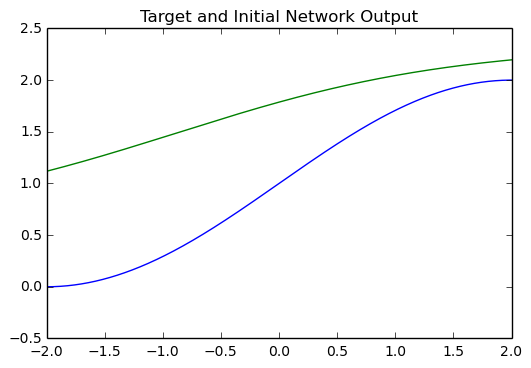

Intial Weights are ...
[array([[ 0.70891842],
       [ 0.93503995]]), array([[ 0.9384916,  0.8161889]])]
_______________________
Intial Biases are ...
[array([[ 0.84940064],
       [ 0.67430854]]), array([[ 0.58895877]])]
_______________________


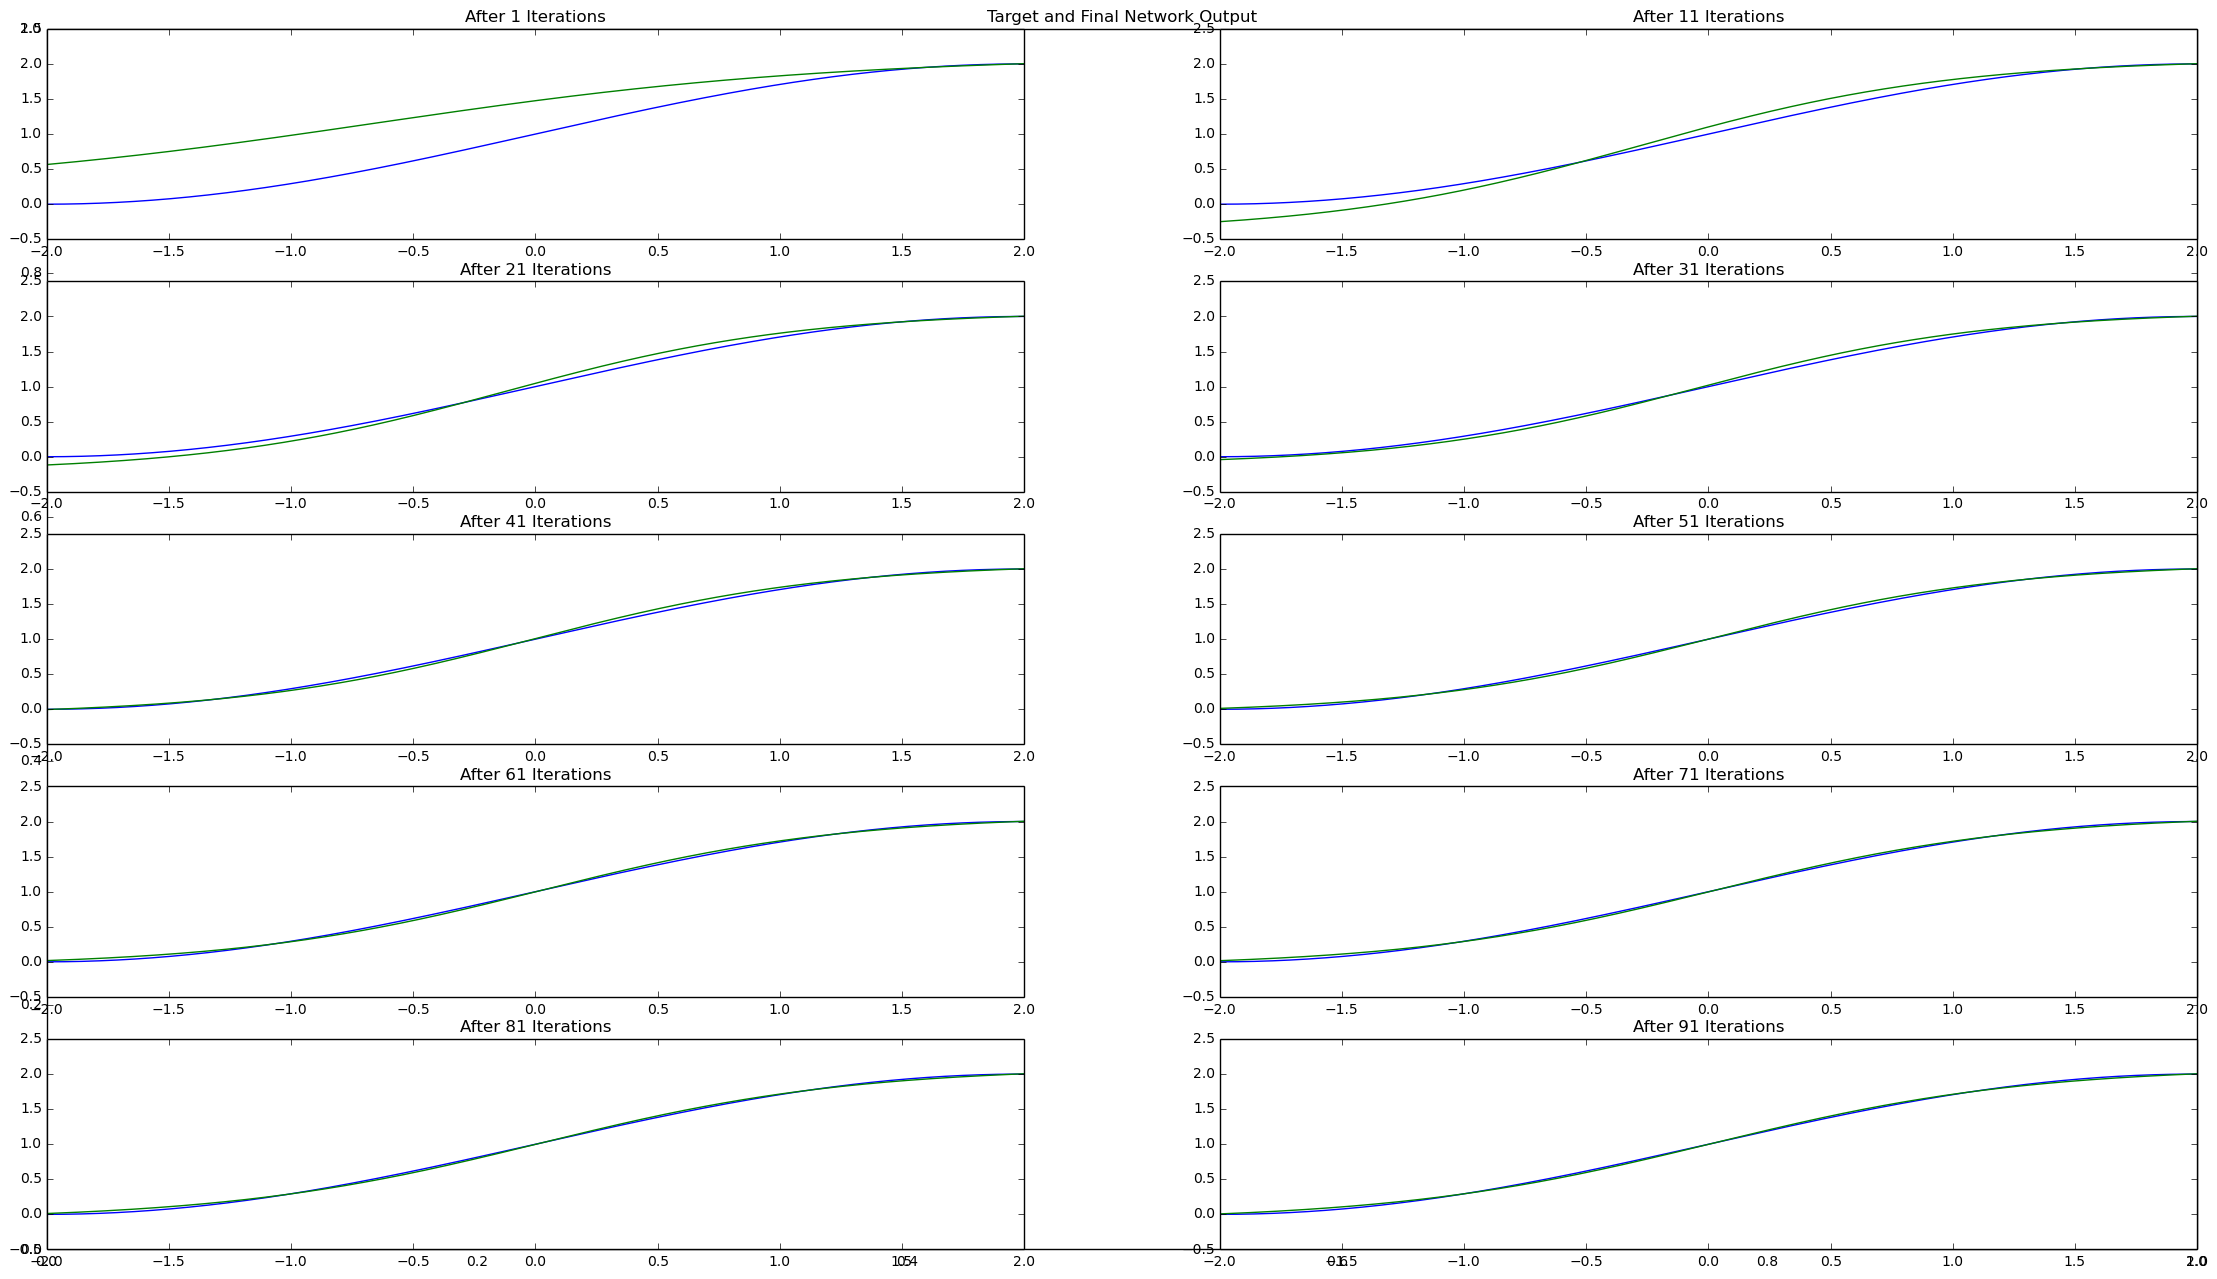

Final Weights are...
[array([[ 1.45947767],
       [ 1.60477158]]), array([[ 1.07713736,  1.12376669]])]
_______________________
Final Biases are ...
[array([[ 0.08068444],
       [-0.08903068]]), array([[-0.09822002]])]
_______________________


In [6]:
functionsTest1 = [np.array([logsig, logsig])[:, newaxis],
                  np.array([purelin])[:, newaxis]]

weightsTest1 = [np.random.random((2, 1)),
                np.random.random((1, 2))]  
biasesTest1 = [np.random.random((2, 1)),  
               np.random.random((1, 1))]     
learningRateTest1 = 0.02

numOfPoints = 1000
inputValuesToNet = np.linspace(-2, 2, numOfPoints)
targetOutputValues = 1 + np.sin(np.pi / 4 * inputValuesToNet)

multilayeredNetworkTest1 = MultilayeredNetwork(functionsTest1, weightsTest1, biasesTest1, learningRateTest1)

# INITIAL OUTPUT OF THE NETWORK
initialNetworkOutputValues = []
for i in range(len(inputValuesToNet)):
    inputToNet = np.array([inputValuesToNet[i]])[:, newaxis]
    initialNetworkOutputValues.append(multilayeredNetworkTest1.getOutput(inputToNet)[0][0])

plt.plot(inputValuesToNet, targetOutputValues)
plt.plot(inputValuesToNet, initialNetworkOutputValues)
plt.ylim(-0.5, 2.5)
plt.title("Target and Initial Network Output")
plt.show()

# INITIAL WEIGHTS OF THE NETWORK
print("Intial Weights are ...")
print(multilayeredNetworkTest1.getWeights())
print("_______________________")
print("Intial Biases are ...")
print(multilayeredNetworkTest1.getBiases())
print("_______________________")

# TRAINING
numOfItrs = 100
fig = plt.figure()
fig.set_size_inches(18.5*1.5, 10.5*1.5)
plt.title("Target and Final Network Output")
for i in range(numOfItrs):
    for j in range(numOfPoints):
        inputToNet = np.array([inputValuesToNet[j]])[:, newaxis]
        target = np.array([targetOutputValues[j]])[:, newaxis]
        multilayeredNetworkTest1.learn(inputToNet, target)
    # OUTPUT OF THE NETWORK AFTER FEW ITERATIONS 
    finalNetworkOutputValues = []
    for j in range(len(inputValuesToNet)):
        inputToNet = np.array([inputValuesToNet[j]])[:, newaxis]
        finalNetworkOutputValues.append(multilayeredNetworkTest1.getOutput(inputToNet)[0][0])
    if i % 10 == 0:
        ax = fig.add_subplot(5, 2, i/10 + 1)
        ax.plot(inputValuesToNet, targetOutputValues)
        ax.plot(inputValuesToNet, finalNetworkOutputValues)
        ax.set_ylim(-0.5, 2.5)
        ax.set_title("After " + str(i+1) + " Iterations")

plt.show()

# FINAL WEIGHTS OF THE NETWORK
print("Final Weights are...")
print(multilayeredNetworkTest1.getWeights())
print("_______________________")
print("Final Biases are ...")
print(multilayeredNetworkTest1.getBiases())
print("_______________________")

### Neuron by Neuron Output

#### Function

In [7]:
def getNeuronOuput(f, w, b, p):
    # w and p are vectors of length n and b is the bias
    # summer returns w_1*p_1 + w_2*p_2 + ... + w_n*p_n + b
    # VARIABLES MUST FOLLOW THE FOLLOWING CONDITIONS...
    # f IS THE TRANSFER FUNCTION OF NEURON
    # w IS A 1-D NUMPY ARRAY CONTAINING WEIGHTS OF NEURON
    # b IS THE BIAS OF NEURON
    # p IS A 1-D NUMPY ARRAY CONTAINING INPUT TO NERUON
    # THE VALUE OF NEURON OUTPUT IS RETURNED
    n = sum(w*p) + b
    return f(n)

# TEST
# f = tansig
# w = np.array([0.5, 1, 1])
# b = 1
# p = np.array([-1, -1, 1])

# print(getNeuronOuput(f, w, b, p))

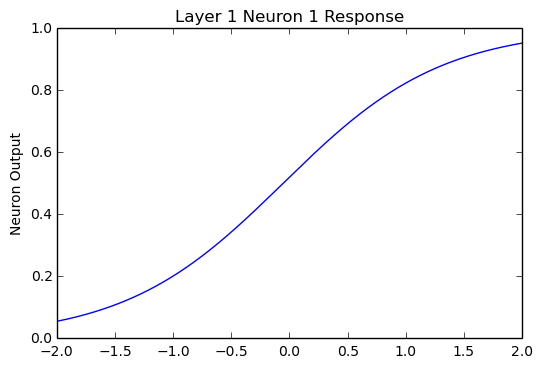

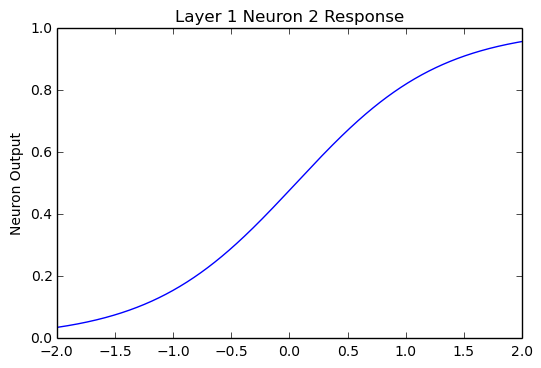

In [8]:
# LAYER 1 NEURON 1 (1 Input)
f = functionsTest1[0][0][0]
w = multilayeredNetworkTest1.getWeights()[0][0]
b = multilayeredNetworkTest1.getBiases()[0][0][0]

layer1neuron1Output = []
for inp in inputValuesToNet:
    p = np.array([inp])
    layer1neuron1Output.append(getNeuronOuput(f, w, b, p))

plt.ylabel("Neuron Output")
plt.plot(inputValuesToNet, layer1neuron1Output)
plt.title("Layer 1 Neuron 1 Response")
plt.show()

# LAYER 1 NEURON 2 (1 Input)
f = functionsTest1[0][1][0]
w = weightsTest1[0][1]
b = biasesTest1[0][1][0]

layer1neuron2Output = []
for inp in inputValuesToNet:
    p = np.array([inp])
    layer1neuron2Output.append(getNeuronOuput(f, w, b, p))

plt.ylabel("Neuron Output")
plt.plot(inputValuesToNet, layer1neuron2Output)
plt.title("Layer 1 Neuron 2 Response")
plt.show()

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


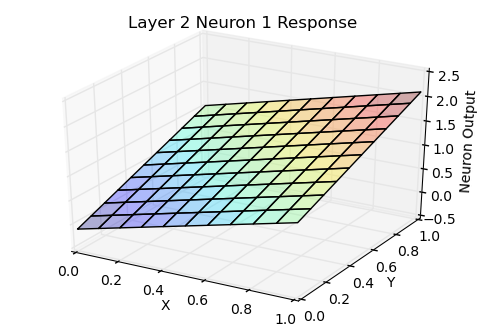

In [9]:
# LAYER 2 NEURON 1 (2 Inputs)
f = functionsTest1[1][0][0]
w = multilayeredNetworkTest1.getWeights()[1][0]
b = multilayeredNetworkTest1.getBiases()[1][0][0]

numOfPoints = 100
x = np.linspace(0, 1, numOfPoints)
y = np.linspace(0, 1, numOfPoints)
X, Y = np.meshgrid(x, y)
layer2neuron1Output = np.zeros((numOfPoints, numOfPoints))
for i in range(numOfPoints):
    for j in range(numOfPoints):
        p = np.array([X[i][j], Y[i][j]])
        layer2neuron1Output[i][j] = getNeuronOuput(f, w, b, p)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection = '3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Neuron Output")
ax.plot_surface(X, Y, layer2neuron1Output, rstride = 10, cstride = 10, alpha = 0.3, cmap = cm.jet)
plt.title("Layer 2 Neuron 1 Response")
plt.show()

### Optimum values found are...
w111 = 1.46748892

w121 = 1.46748892

w211 = 1.13266783

w212 = 1.13266783

b11 = 0.04471949

b12 = 0.04471949

b21 = -0.15142791

### Performance Measure with Layer One (Both Neurons) Weights

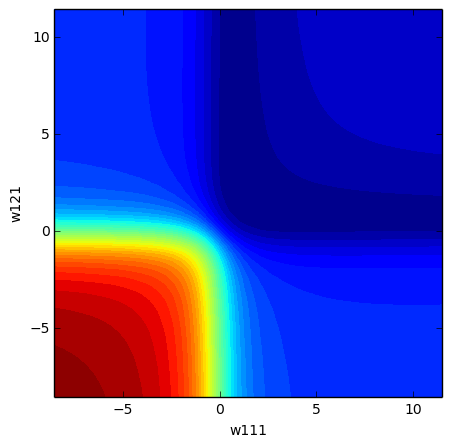

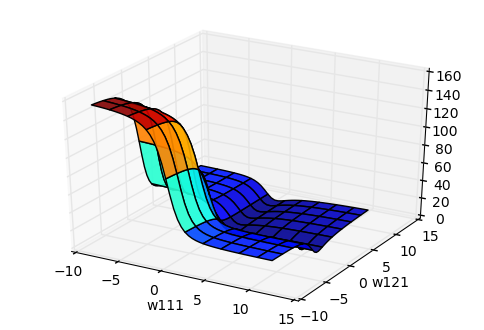

In [10]:
cuts = 50
w111 = np.linspace(1.46748892 - 10, 1.46748892 + 10, cuts)
w121 = np.linspace(1.46748892 - 10, 1.46748892 + 10, cuts)
W111, W121 = np.meshgrid(w111, w121)
errorValuesFromNet = np.zeros((cuts, cuts))

# For every test...
inputValuesToNet = np.linspace(-2, 2, cuts)
targetOutputValues = 1 + np.sin(np.pi / 4 * inputValuesToNet)
for i in range(cuts):
    for j in range(cuts):
        # Calculate the outputValues for given w111, b121
        f = [np.array([logsig, logsig])[:, newaxis],
             np.array([purelin])[:, newaxis]]
        w = [np.array([[W111[i][j]],
                       [W121[i][j]]]), 
             np.array([[ 1.13266783,  1.13266783]])]
        b = [np.array([0.14112438, 0.04471949])[:, newaxis], 
             np.array([-0.15142791])[:, newaxis]]
        outputValues = []
        for inp in inputValuesToNet:
            outputValues.append(getMultipleLayerOutput(f, w, b, np.array([[inp]]))[0][0])
        # Calculate the error for the given Values, enter into errorValuesFromNet
        error = sum((targetOutputValues - outputValues)**2)
        errorValuesFromNet[i][j] = error

plt.figure(figsize=[5, 5])
cs = plt.contourf(W111, W121, errorValuesFromNet, cuts, cmap = cm.jet)
plt.xlabel("w111")
plt.ylabel("w121")
plt.show()
plt.figure()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection = '3d')
ax.plot_surface(W111, W121, errorValuesFromNet, 
                rstride = cuts/10, cstride = cuts/10, 
                alpha = 0.9, cmap = cm.jet)
ax.set_xlabel("w111")
ax.set_ylabel("w121")
plt.show()

### Starting From Bad Points

Now, starting from the mountain near $(10, 10)$, we get to optimum points and observe the graph.

We will only update the weigths we want to observe so that our plot above remains valid and we can see the changes along that surface plot. To do that, we have to define a new function that allows us to change weights for a single layer of neurons in complete network.

In [11]:
def teachLayerWeightsByBackpropagation(self, inputToNet, target, layerNumber):
    # LAYER NUMBER MUST BE A INT. ONE REFERS TO FIRST LAYER, TWO TO SECOND LAYER AND SO ON...
    M = self.getNumberOfLayers()
    a_Matrix = self.getCompleteOutput(inputToNet)
    sensi = []
    derivMatrix = getDerivativeMatrix(self.getFunctions(-1), a_Matrix[-1])
    sensi = [(-2 * derivMatrix.dot(target - a_Matrix[-1]))] + sensi     
    for m in reversed(range(0, M-1)):
        derivMatrix = getDerivativeMatrix(self.getFunctions(m), a_Matrix[m])
        sensi = [derivMatrix.dot(self.weights[m+1].transpose()).dot(sensi[0])] + sensi    
    # UPDATE THE WEIGHTS
    m = layerNumber - 1
    self.weights[m] = self.weights[m] - self.learningRate * sensi[m].dot(a_Matrix[m-1].transpose())

MultilayeredNetwork.teachLayerWeights = teachLayerWeightsByBackpropagation

Since we will need error again and again, we define a error function where input values and target output values are arguments. In addition to this, we create a function that give out values of output for multiple inputs at a particular moment.

In [12]:
def getOutputsOneInOneOut(self, inputValues):
    # THIS FUNCTION IS USED WHEN NUMBER OF INPUTS AND NUMBER OF OUTPUTS EQUAL ONE.
    outputValues = []
    for i in range(len(inputValues)):
        outputValues.append(self.getOutput(
            np.array([inputValues[i]])[:, newaxis])[0][0])
    return outputValues
    
MultilayeredNetwork.getOutputsOneInOneOut = getOutputsOneInOneOut
    
def getErrorOneInOneOut(self, inputValues, targetValues):
    # THIS FUNCTION IS USED WHEN NUMBER OF INPUTS AND NUMBER OF OUTPUTS EQUAL ONE.
    outputValues = self.getOutputsOneInOneOut(inputValues)
    return sum((targetValues - outputValues)**2)

MultilayeredNetwork.getErrorOneInOneOut = getErrorOneInOneOut

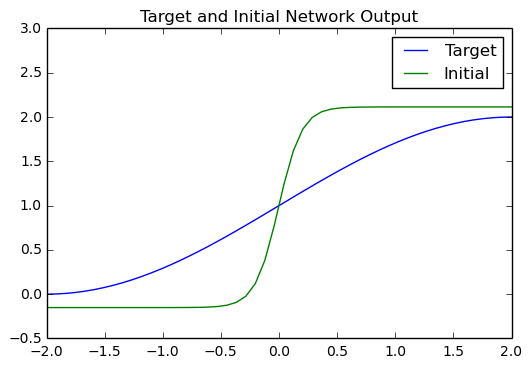

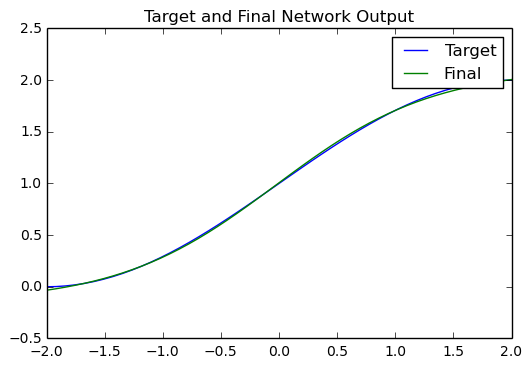

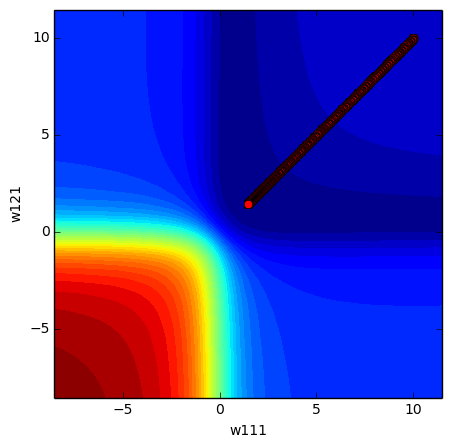

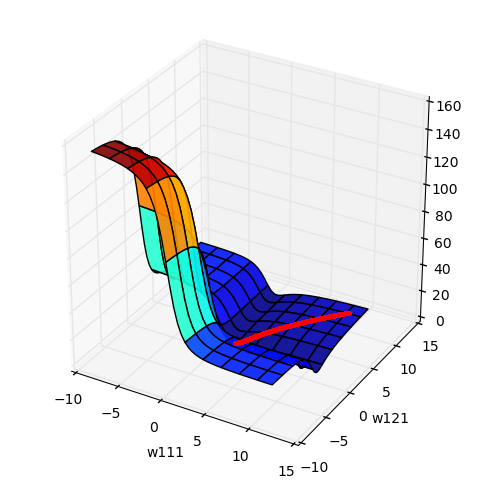

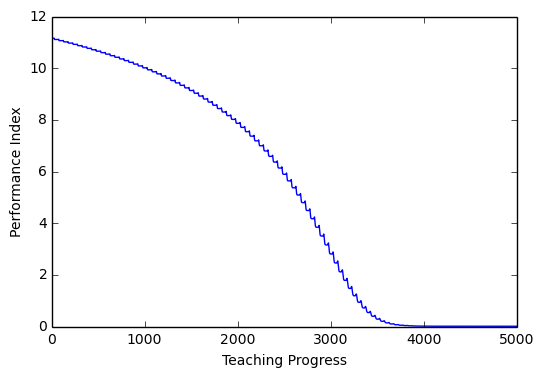

In [13]:
def tryWithInitValues(initW111, initW121, numOfItrs):
    # SETTING UP INPUT VALUES TO NET AND TARGET OUTPUTVALUES
    inputValuesToNet = np.linspace(-2, 2, cuts)
    targetOutputValues = 1 + np.sin(np.pi / 4 * inputValuesToNet)

    # INITIALIZE NETWORK
    multilayeredNetworkTest3 = MultilayeredNetwork([np.array([logsig, logsig])[:, newaxis],         # functions
                                                    np.array([purelin])[:, newaxis]], 
                                                   [np.array([[initW111],                           # weights
                                                              [initW121]]),      
                                                    np.array([[1.13266783, 1.13266783]])], 
                                                   [np.array([0.04471949, 0.04471949])[:, newaxis], # biases
                                                    np.array([-0.15142791])[:, newaxis]], 
                                                   0.1)                                            # learning rate



    # INITIAL OUTPUT OF THE NETWORK
    initialOutputValues = multilayeredNetworkTest3.getOutputsOneInOneOut(inputValuesToNet)
    line1, = plt.plot(inputValuesToNet, targetOutputValues)
    line2, = plt.plot(inputValuesToNet, initialOutputValues)
    plt.legend([line1, line2], ["Target", "Initial"])
    plt.ylim(-0.5, 3.0)
    plt.title("Target and Initial Network Output")
    plt.show()

    # INITALIZE WEIGHTS PATH TO BE FOLLOWED BY NETWORK
    pathW111 = [initW111]
    pathW121 = [initW121]
    pathErrorValues = [sum((targetOutputValues - initialOutputValues)**2)]

    # TRAINING
    for i in range(numOfItrs):
        for j in range(cuts):
            inputToNet = np.array([inputValuesToNet[j]])[:, newaxis]
            target = np.array([targetOutputValues[j]])[:, newaxis]
            multilayeredNetworkTest3.teachLayerWeights(inputToNet, target, 1)
            # OUTPUT OF THE NETWORK AFTER EVERY TEACHING ...
            #     Calulate error and add to pathErrorValues...
            error = multilayeredNetworkTest3.getErrorOneInOneOut(inputValuesToNet, targetOutputValues)

            pathW111.append(multilayeredNetworkTest3.getWeights()[0][0][0])
            pathW121.append(multilayeredNetworkTest3.getWeights()[0][0][0])
            pathErrorValues.append(error)

    # MAKING UP A PLOT OF TARGET AND FINAL NETWORK OUTPUT 
    finalNetworkOutputValues = multilayeredNetworkTest3.getOutputsOneInOneOut(inputValuesToNet)
    line2, = plt.plot(inputValuesToNet, targetOutputValues)
    line2, = plt.plot(inputValuesToNet, finalNetworkOutputValues)
    plt.legend([line1, line2], ["Target", "Final"])
    plt.ylim(-0.5, 2.5)
    plt.title("Target and Final Network Output")
    plt.show()

    # MAKING UP A 2-D CONTOUR PLOT FOR ERRORS
    plt.figure(figsize=[5, 5])
    plt.contourf(W111, W121, errorValuesFromNet, cuts, cmap = cm.jet)
    plt.plot(pathW111, pathW121, 'ro')
    plt.xlabel("w111")
    plt.ylabel("w121")
    plt.show()

    # MAKING UP A 3-D SURFACE PLOT FOR ERRORS
    fig = plt.figure()
    fig.set_figheight(6)
    fig.set_figwidth(6)
    ax = fig.add_subplot(1, 1, 1, projection = '3d')
    ax.set_xlabel("w111")
    ax.set_ylabel("w121")
    ax.plot(pathW111, pathW121, pathErrorValues, 'r.')
    ax.plot_surface(W111, W121, errorValuesFromNet, 
                      rstride = cuts/10, cstride = cuts/10, 
                      alpha = 0.9, cmap = cm.jet)
    # ax.view_init(45, -60)
    plt.show()

    plt.plot(pathErrorValues)
    plt.xlabel("Teaching Progress")
    plt.ylabel("Performance Index")
    plt.show()

tryWithInitValues(10, 10, 100)

Observe how, in the first interation, network learns and jump directly to a much better value of weights. Now, using same code, we try with $(-2, -2)$...

(Also, note how the performance index fluctuates a lot much. A PROBLEM TO BE HANDLED.)

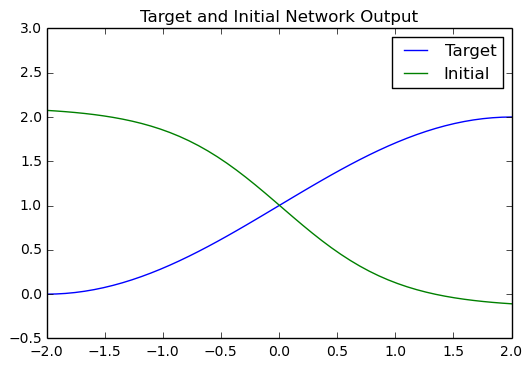

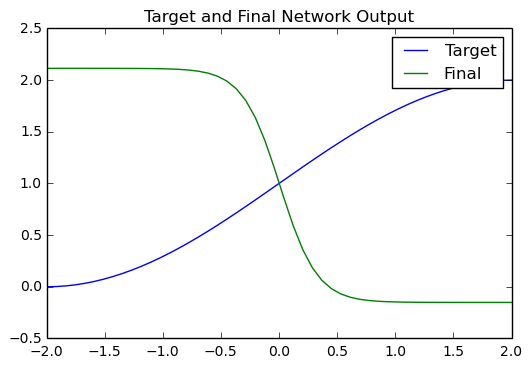

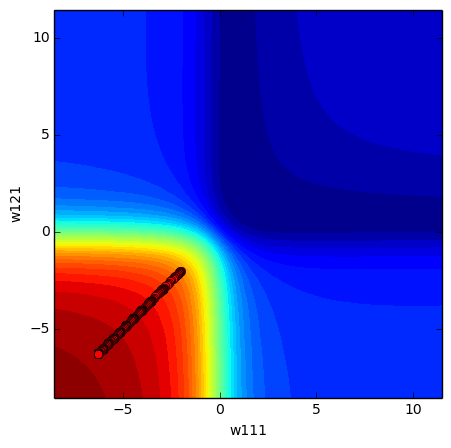

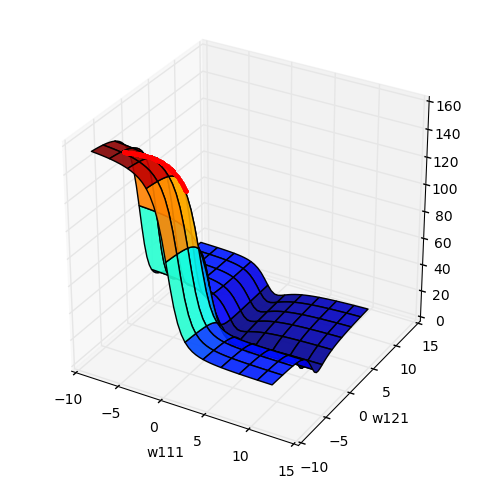

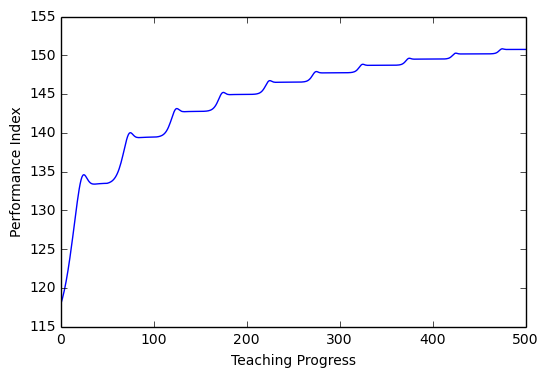

In [14]:
tryWithInitValues(-2, -2, 10)

Observe how network goes exactly in the wrong direction (this has nothing to do with learning rate, checked!) probably because of not updating the other variable simultaneously. Let's make sure that network is working properly... (code copied from above, teachLayerWeights is replaced by learn)

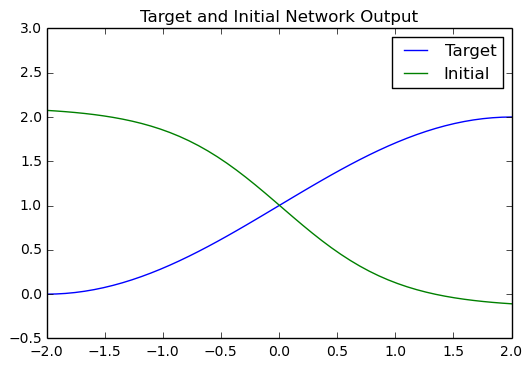

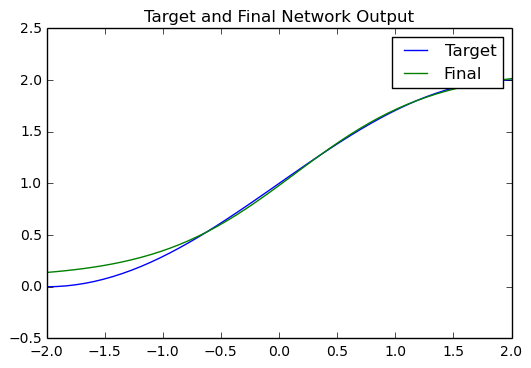

/usr/lib/pymodules/python2.7/matplotlib/collections.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':


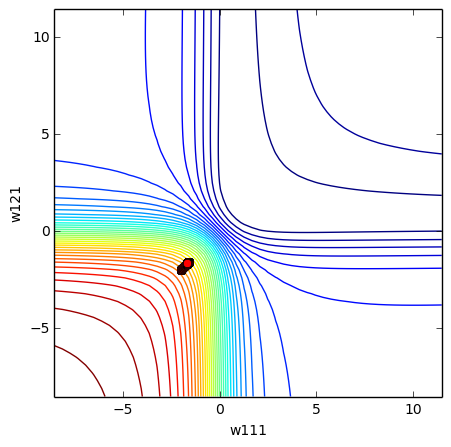

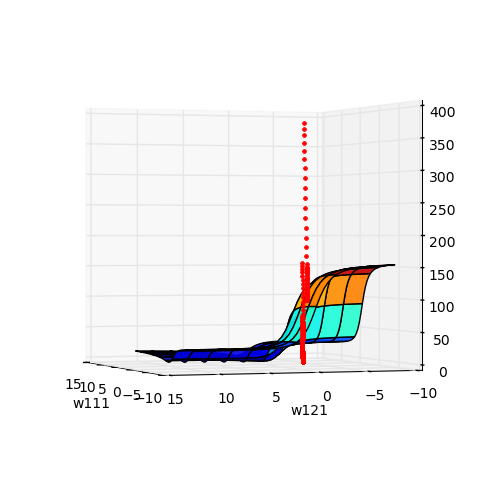

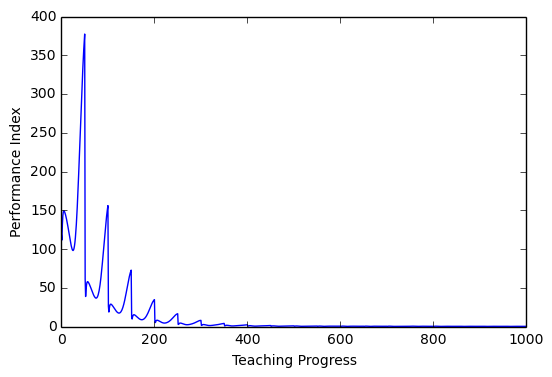

Final Weights are...
[array([[-1.65973635],
       [-1.65973635]]), array([[-1.01016666, -1.01016666]])]
Final Biases are...
[array([[ 0.22116462],
       [ 0.22116462]]), array([[ 2.10189253]])]


In [15]:
def normalTeaching(initW111, initW121, numOfItrs):
    # SETTING UP INPUT VALUES TO NET AND TARGET OUTPUTVALUES
    inputValuesToNet = np.linspace(-2, 2, cuts)
    targetOutputValues = 1 + np.sin(np.pi / 4 * inputValuesToNet)

    # INITIALIZE NETWORK
    multilayeredNetworkTest3 = MultilayeredNetwork([np.array([logsig, logsig])[:, newaxis],         # functions
                                                    np.array([purelin])[:, newaxis]], 
                                                   [np.array([[initW111],                           # weights
                                                              [initW121]]),      
                                                    np.array([[1.13266783, 1.13266783]])], 
                                                   [np.array([0.04471949, 0.04471949])[:, newaxis], # biases
                                                    np.array([-0.15142791])[:, newaxis]], 
                                                   0.1)                                             # learning rate



    # INITIAL OUTPUT OF THE NETWORK
    initialOutputValues = multilayeredNetworkTest3.getOutputsOneInOneOut(inputValuesToNet)
    line1, = plt.plot(inputValuesToNet, targetOutputValues)
    line2, = plt.plot(inputValuesToNet, initialOutputValues)
    plt.legend([line1, line2], ["Target", "Initial"])
    plt.ylim(-0.5, 3.0)
    plt.title("Target and Initial Network Output")
    plt.show()

    # INITALIZE WEIGHTS PATH TO BE FOLLOWED BY NETWORK
    pathW111 = [initW111]
    pathW121 = [initW121]
    pathErrorValues = [sum((targetOutputValues - initialOutputValues)**2)]

    # TRAINING
    for i in range(numOfItrs):
        for j in range(cuts):
            inputToNet = np.array([inputValuesToNet[j]])[:, newaxis]
            target = np.array([targetOutputValues[j]])[:, newaxis]
            multilayeredNetworkTest3.learn(inputToNet, target)
            # OUTPUT OF THE NETWORK AFTER EVERY TEACHING ...
            #     Calulate error and add to pathErrorValues...
            error = multilayeredNetworkTest3.getErrorOneInOneOut(inputValuesToNet, targetOutputValues)

            pathW111.append(multilayeredNetworkTest3.getWeights()[0][0][0])
            pathW121.append(multilayeredNetworkTest3.getWeights()[0][0][0])
            pathErrorValues.append(error)

    # MAKING UP A PLOT OF TARGET AND FINAL NETWORK OUTPUT 
    finalNetworkOutputValues = multilayeredNetworkTest3.getOutputsOneInOneOut(inputValuesToNet)
    line2, = plt.plot(inputValuesToNet, targetOutputValues)
    line2, = plt.plot(inputValuesToNet, finalNetworkOutputValues)
    plt.legend([line1, line2], ["Target", "Final"])
    plt.ylim(-0.5, 2.5)
    plt.title("Target and Final Network Output")
    plt.show()

    # MAKING UP A 2-D CONTOUR PLOT FOR ERRORS
    plt.figure(figsize=[5, 5])
    plt.contour(W111, W121, errorValuesFromNet, cuts, cmap = cm.jet)
    plt.plot(pathW111, pathW121, 'ro')
    plt.xlabel("w111")
    plt.ylabel("w121")
    plt.show()

    # MAKING UP A 3-D SURFACE PLOT FOR ERRORS
    fig = plt.figure()
    fig.set_figheight(6)
    fig.set_figwidth(6)
    ax = fig.add_subplot(1, 1, 1, projection = '3d')
    ax.set_xlabel("w111")
    ax.set_ylabel("w121")
    ax.plot(pathW111, pathW121, pathErrorValues, 'r.')
    ax.plot_surface(W111, W121, errorValuesFromNet, 
                      rstride = cuts/10, cstride = cuts/10, 
                      alpha = 0.9, cmap = cm.jet)
    ax.view_init(0, 160)
    plt.show()

    plt.plot(pathErrorValues)
    plt.xlabel("Teaching Progress")
    plt.ylabel("Performance Index")
    plt.show()
    
    print("Final Weights are...")
    print(multilayeredNetworkTest3.getWeights())
    print("Final Biases are...")
    print(multilayeredNetworkTest3.getBiases())

normalTeaching(-2, -2, 20)

Observe how network has convergered to a stable point but not with the biases and layer two weight we were experimenting with.

### Randomized Data Set 

Now we consider the observation of fluctuating performance index which is probably because, as the network learns the given dataset in line, it realigns itself for a given data points and forgets that learning by the time iteration is complete. Here we try by shuffling the data set... (copying the code used with $teachLayerWeights$ function and shuffling $inputValuesToNet$ before feeding)

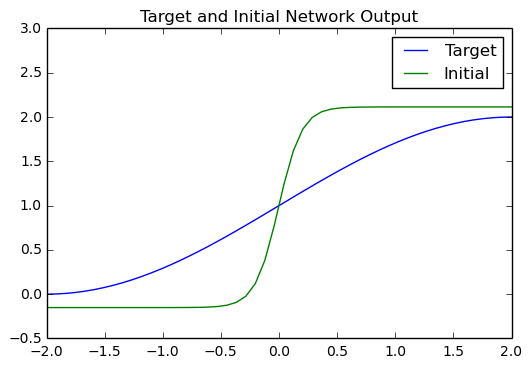

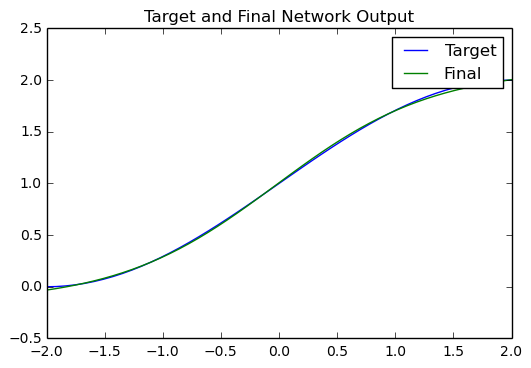

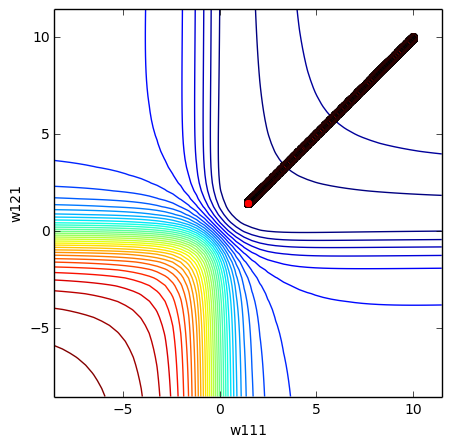

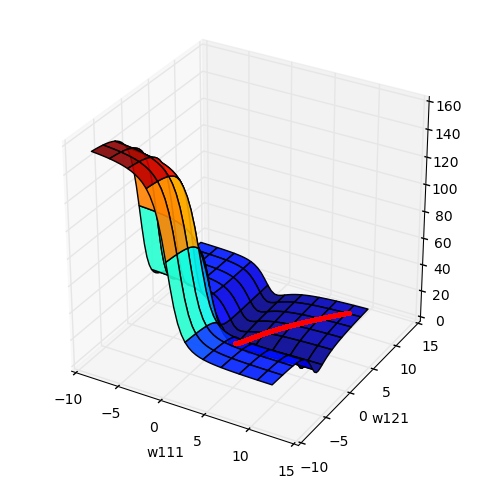

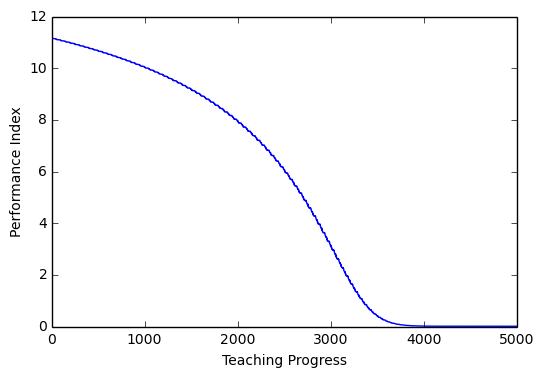

In [16]:
def tryWithInitValues2(initW111, initW121, numOfItrs):
    # SETTING UP INPUT VALUES TO NET AND TARGET OUTPUTVALUES
    actualValuesToNet = np.linspace(-2, 2, cuts)
    actualTargetsToNet = 1 + np.sin(np.pi / 4 * actualValuesToNet)
    inputValuesToNet = np.linspace(-2, 2, cuts)
    random.shuffle(inputValuesToNet)
    targetOutputValues = 1 + np.sin(np.pi / 4 * inputValuesToNet)

    # INITIALIZE NETWORK
    multilayeredNetworkTest3 = MultilayeredNetwork([np.array([logsig, logsig])[:, newaxis],         # functions
                                                    np.array([purelin])[:, newaxis]], 
                                                   [np.array([[initW111],                           # weights
                                                              [initW121]]),      
                                                    np.array([[1.13266783, 1.13266783]])], 
                                                   [np.array([0.04471949, 0.04471949])[:, newaxis], # biases
                                                    np.array([-0.15142791])[:, newaxis]], 
                                                   0.1)                                            # learning rate



    # INITIAL OUTPUT OF THE NETWORK
    initialOutputValues = multilayeredNetworkTest3.getOutputsOneInOneOut(actualValuesToNet)
    line1, = plt.plot(actualValuesToNet, actualTargetsToNet)
    line2, = plt.plot(actualValuesToNet, initialOutputValues)
    plt.legend([line1, line2], ["Target", "Initial"])
    plt.ylim(-0.5, 3.0)
    plt.title("Target and Initial Network Output")
    plt.show()

    # INITALIZE WEIGHTS PATH TO BE FOLLOWED BY NETWORK
    pathW111 = [initW111]
    pathW121 = [initW121]
    pathErrorValues = [sum((targetOutputValues - 
                            multilayeredNetworkTest3.getOutputsOneInOneOut(inputValuesToNet))**2)]

    # TRAINING
    for i in range(numOfItrs):
        for j in range(cuts):
            inputToNet = np.array([inputValuesToNet[j]])[:, newaxis]
            target = np.array([targetOutputValues[j]])[:, newaxis]
            multilayeredNetworkTest3.teachLayerWeights(inputToNet, target, 1)
            # OUTPUT OF THE NETWORK AFTER EVERY TEACHING ...
            #     Calulate error and add to pathErrorValues...
            error = multilayeredNetworkTest3.getErrorOneInOneOut(inputValuesToNet, targetOutputValues)

            pathW111.append(multilayeredNetworkTest3.getWeights()[0][0][0])
            pathW121.append(multilayeredNetworkTest3.getWeights()[0][0][0])
            pathErrorValues.append(error)

    # MAKING UP A PLOT OF TARGET AND FINAL NETWORK OUTPUT 
    finalNetworkOutputValues = multilayeredNetworkTest3.getOutputsOneInOneOut(actualValuesToNet)
    line2, = plt.plot(actualValuesToNet, actualTargetsToNet)
    line2, = plt.plot(actualValuesToNet, finalNetworkOutputValues)
    plt.legend([line1, line2], ["Target", "Final"])
    plt.ylim(-0.5, 2.5)
    plt.title("Target and Final Network Output")
    plt.show()

    # MAKING UP A 2-D CONTOUR PLOT FOR ERRORS
    plt.figure(figsize=[5, 5])
    plt.contour(W111, W121, errorValuesFromNet, cuts, cmap = cm.jet)
    plt.plot(pathW111, pathW121, 'ro')
    plt.xlabel("w111")
    plt.ylabel("w121")
    plt.show()

    # MAKING UP A 3-D SURFACE PLOT FOR ERRORS
    fig = plt.figure()
    fig.set_figheight(6)
    fig.set_figwidth(6)
    ax = fig.add_subplot(1, 1, 1, projection = '3d')
    ax.set_xlabel("w111")
    ax.set_ylabel("w121")
    ax.plot(pathW111, pathW121, pathErrorValues, 'r.')
    ax.plot_surface(W111, W121, errorValuesFromNet, 
                      rstride = cuts/10, cstride = cuts/10, 
                      alpha = 0.9, cmap = cm.jet)
    # ax.view_init(45, -60)
    plt.show()

    plt.plot(pathErrorValues)
    plt.xlabel("Teaching Progress")
    plt.ylabel("Performance Index")
    plt.show()

tryWithInitValues2(10, 10, 100)

As it can be seen above, the performance index variation as network is taught is smoothened out. 

### Performance Measure With Layer One (Both Neurons) Biases

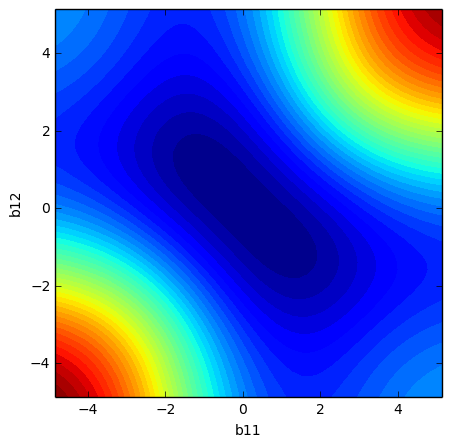

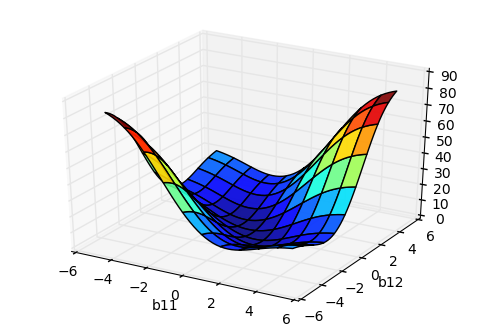

In [17]:
cuts = 50
B11, B12 = np.meshgrid(np.linspace(0.14112438 - 5, 0.14112438 + 5, cuts), 
                       np.linspace(0.14112438 - 5, 0.14112438 + 5, cuts))
errorValuesFromNet = np.zeros((cuts, cuts))

# For every test...
inputValuesToNet = np.linspace(-2, 2, cuts)
targetOutputValues = 1 + np.sin(np.pi / 4 * inputValuesToNet)
for i in range(cuts):
    for j in range(cuts):
        # Calculate the outputValues for given b11, b12
        outputValues = []
        for inp in inputValuesToNet:
            outputValues.append(getMultipleLayerOutput([np.array([logsig, logsig])[:, newaxis],        # functions
                                                        np.array([purelin])[:, newaxis]], 
                                                       [np.array([[1.46748892],                        # weights
                                                                  [1.46748892]]), 
                                                        np.array([[1.13266783,  
                                                                   1.13266783]])], 
                                                       [np.array([B11[i][j], B12[i][j]])[:, newaxis],  # biases
                                                        np.array([-0.15142791])[:, newaxis]], 
                                                       np.array([[inp]]))[0][0])                       # inputs
        # Calculate the error for the given Values, enter into errorValuesFromNet
        error = sum((targetOutputValues - outputValues)**2)
        errorValuesFromNet[i][j] = error

plt.figure(figsize=[5, 5])
cs = plt.contourf(B11, B12, errorValuesFromNet, cuts, cmap = cm.jet)
plt.xlabel("b11")
plt.ylabel("b12")
plt.show()
plt.figure()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection = '3d')
ax.plot_surface(B11, B12, errorValuesFromNet, 
                rstride = cuts/10, cstride = cuts/10, 
                alpha = 0.9, cmap = cm.jet)
ax.set_xlabel("b11")
ax.set_ylabel("b12")
plt.show()